# Trivial example: linear regression

This is a rather trivial example, but it contains all necessary elements to train an emulator using Feed Forward Neural Networks alghorithms. In particular we are going to use Machine Learning to learn a linear relation of this type
$$
y = a\cdot x + b
$$
where $a$ and $b$ are parameters and $x$ is the unique feature.

To do so, the main tasks will be:
- generate a dataset
- build and train a simple architecture
- test what the emulator learned.

NOTE: this example contains enough documentation to learn the basics. In case, refer to the `*.yaml` files in the main root for additional information about the parameters to use and the possible choices.

### Load libraries and initialise relevant classes

Load libraries: in this example we are first going to generate a dataset (using the DataCollection class), and then build an emulator (using the FFNNEmu class). Here we are calling diectly the architecture we are going to use (instead of the base Emulator class), but it would be equivalent to call Emulator with a string specifying the type of emulator.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from emu_like.datasets import DataCollection
from emu_like.ffnn_emu import FFNNEmu

2025-07-14 16:43:00.617983: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-14 16:43:00.618466: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-14 16:43:00.620733: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-14 16:43:00.626086: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752504180.635960  162442 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752504180.63

In [2]:
data = DataCollection()
emu = FFNNEmu()

### Generate the dataset

To generate a dataset we have just to call the `DataCollection.sample()` method, passing the proper parameters (for more exhaustive information see `*_sample.yaml` files):
- `params`: (dict) dictionary with the features (see below);
- `x_name` (str): name of the x sampler (grid, latin_hypercube, ...);
- `x_args` (dict): parameters needed by the x sampler (n_samples, ...);
- `y_name` (str): name of the y model (linear_1D, quadratic_1D, ...);
- `y_args` (str): parameters needed by the y_model (see below);
- `y_outputs` (dict): the class_spectra y_model save the output in different files, for the other models leave it None;
- `output` (str): if we want to save the output to a folder use this;
- `save_incrementally` (bool): for long calculations saves incrementally the result;
- `verbose` (bool): verbosity.

For simple examples you need to specify only `params`, `x_name`, `y_name`, and their arguments (if any).


Let us focus on a specific example.
We are going to try to fit a linear relation of the type
$$
y = a\cdot x + b
$$
as defined in the `Linear1D` class in `src/emu_like/y_models.py`.
$x$ is a single scalar feature, while $a$ and $b$ are fixed parameters.

We define two dictionaries, one corresponding to `params` and one to `y_args`. Each argument should have just a value, while for variables we need to specify a prior. The `prior` key should contain `min` and `max` parameters in most cases, except for gaussianly distributed priors, where `loc` (mean) and `scale` (standard deviation) keys are expected.

Defining a custom function is relatively simple: just add a new class to `src/emu_like/y_models.py`, mimicking the existing ones.

In [3]:
# Features
params = {
  'x': {
      'prior': {
          'min': -1.,
          'max': 4.,
      },
  },
}

# Arguments
y_args = {
  'a': 2.,
  'b': -1.

}

Now we do the actual run

In [4]:
data.sample(
    params=params,
    x_name='grid',
    x_args={'n_samples': 1000},
    y_name='linear_1d',
    y_args=y_args,
    verbose=True)

[info] Generating dataset.
[info] Initializing Grid sampler.
----> Number of samples: 1000
[info] Initializing Linear1D model.


100%|██████████| 1000/1000 [00:00<00:00, 1298144.23it/s]


**NOTE**: the following step may be considered as redoundant but it is not. In the `src/emu_like/datasets.py` file, we define two main classes `DataCollection` (the one used now) and `Dataset`. The first one deals with multiple `y`'s (each one is a separate array with possibly multiple targets). As a result the `y` data are stored in a list of 2D arrays (for this specific case we have just one array). However, for training a ML algorithm we want to use just one `y` (that's why we divided them). This is the goal of the `Dataset` class. It contains just one `y`. A `Dataset` is stored in the `DataCollection().one_y_dataset` attribute. This is automatically filled if we have just one `y` (as in this case), otherwise one can use the `DataCollection().get_one_y_dataset(name)` method to specify which `y` to select.

In [5]:
data = data.get_one_y_dataset()

data.train_test_split(
    frac_train=0.9,
    seed=1543,
    verbose=True)

[info] Splitting dataset in training and testing samples.
----> Fractional number of training samples: 0.9
----> Random seed for train/test split: 1543


To train more efficiently the emulator it is often useful to rescale both `x` and `y` to have them of order 1. The list of possible scalers can be found at `simple_train.yaml` (or in the source code at `src/emu_like/scalers.py`, where you can also add new scalers).

In [6]:
data.rescale(
    rescale_x = 'StandardScaler',
    rescale_y = 'MinMaxScalerPlus1',
    verbose=True)

[info] Rescaling x and y.
----> x with: StandardScaler
----> y with: MinMaxScalerPlus1
----> Rescaled bounds:
--------> x_train_0 = [-1.7284147042373472, 1.7432962234401823]
--------> x_test_0 = [-1.7179891458959733, 1.7328706650988084]
--------> y_train_0 = [1.0, 2.0]
--------> y_test_0 = [1.003003003003003, 1.9969969969969972]


### Build and train the emulator

After the dataset is generated, we have to build the emulator architecture and train it.
Building the architecture consists in defining a set of parameters `params` and pass it to the `build` method. The parameters one should specify are listed below, and they are explained in depth in the `*_train.yaml`, with two exceptions:
- `data_n_x`: number of features;
- `data_n_y`: number of targets;

In particular, for linear regression a neural network can be very simple, i.e. without hidden layers.

In [7]:
params = {
    'activation': 'relu',
    'neurons_hidden': [],
    'batch_normalization': False,
    'dropout_rate': 0.,
    'batch_size': 32,
    'optimizer': 'adam',
    'loss': 'mean_squared_error',
    'want_output_layer': True,
    'data_n_x': data.n_x,
    'data_n_y': data.n_y,
}

In [8]:
emu.build(
    params,
    verbose=True)

[info] Building FFNN architecture
----> Activation function: relu
----> Dropout rate: 0.0
----> Optimizer: adam
----> Loss function: mean_squared_error


2025-07-14 16:43:01.530347: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (32, 1)                │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

It is now time to train the emulator. One has to pass a Dataset object (already loaded, splitted into train and test samples and rescaled), the number of `epochs`, the `learning_rate` and the `batch_size`. It is possible also to save the emulator providing `path`

Epoch 1/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.1882 - val_loss: 6.5216
Epoch 2/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8928 - val_loss: 6.3165
Epoch 3/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7690 - val_loss: 6.1131
Epoch 4/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6580 - val_loss: 5.9151
Epoch 5/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4728 - val_loss: 5.7216
Epoch 6/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9558 - val_loss: 5.5333
Epoch 7/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9575 - val_loss: 5.3450
Epoch 8/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8785 - val_loss: 5.1628
Epoch 9/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5611 - val_loss: 4.9875
Epoch 10/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4064 - val_loss: 4.8159
Epoch 11/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3269 - val_loss: 4.6447
Epoch 12/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

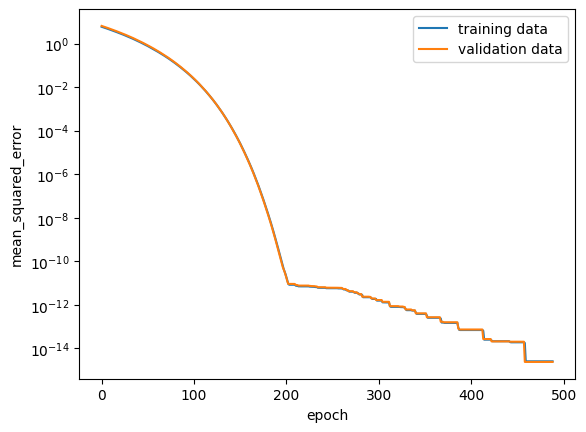

In [ ]:
emu.train(
    data,
    epochs=1000,
    learning_rate=1.e-3,
    patience=100,
    path=None,
    get_plots=True,
    verbose=True)

This plot shows the evolution of the loss function per epoch, evaluated for the training data and the validation data. It is possible to notice that the loss function starts high and then decreases, reaching a plateau. After that both datasets start scattering. This indicates that the learning rate could be decreased. However, since the accuracy reached is good enough we just stop the emulator and use that.

### Testing the result

In 1D we can test the emulator just visually. The first plot shows the sampled data vs the emulated ones. The second plot show the absolute value of the relative difference between the two.

In [10]:
y_emu = np.array([emu.eval(x) for x in data.x])

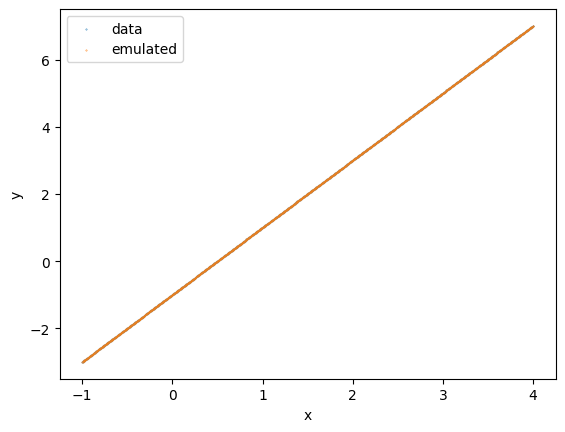

In [11]:
plt.scatter(data.x[:,0], data.y[:,0], s=0.1, label='data')
plt.scatter(data.x[:,0], y_emu[:,0], s=0.1, label='emulated')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

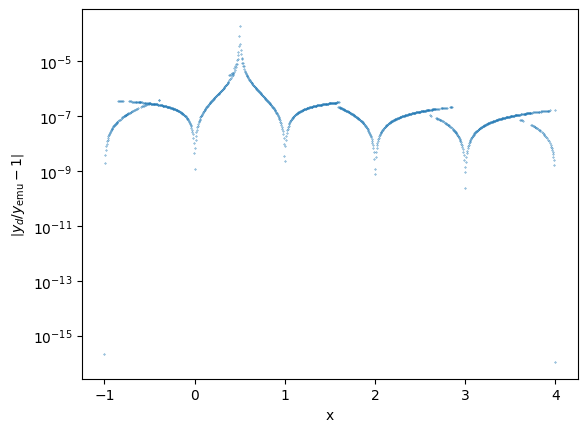

In [12]:
plt.scatter(data.x[:,0], np.abs(y_emu[:,0]/data.y[:,0]-1.), s=0.1)
plt.xlabel('x')
plt.ylabel('$\\left|y_d/y_\\mathrm{emu}-1\\right|$')
plt.yscale('log')